<a href="https://colab.research.google.com/github/thimeshaA/BrineXCompass-landowner_decision_support_system/blob/main/Seller_Recommendation_(CatBoost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import json

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Load Datasets

**Dataset 1:** `seller_recommendation_training_data.xlsx`
- Used for: Model 1 (Seller RL), Model 3 (Price Prediction)

**Dataset 2:** `monthly_market_aggregates.xlsx`
- Used for: Model 2 (Harvest Timing RL), Model 4 (Forecasting)

In [36]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [46]:
# Load datasets
print("Loading datasets...\n")
BASE_PATH = '/content/drive/MyDrive/BrineXCompass'

df_transactions = pd.read_excel(f'{BASE_PATH}/seller_recommendation_training_data.xlsx')
print(f"✓ Dataset 1 (Transactions): {df_transactions.shape[0]} rows, {df_transactions.shape[1]} columns")

df_market = pd.read_excel(f'{BASE_PATH}/monthly_market_aggregates.xlsx')
print(f"✓ Dataset 2 (Market Aggregates): {df_market.shape[0]} rows, {df_market.shape[1]} columns")

print("\n✅ Both datasets loaded successfully!")

Loading datasets...

✓ Dataset 1 (Transactions): 6194 rows, 30 columns
✓ Dataset 2 (Market Aggregates): 163 rows, 12 columns

✅ Both datasets loaded successfully!


## Create Models Directory

In [40]:
models_dir = Path('models-Compass')
models_dir.mkdir(exist_ok=True)
print(f"✓ Models directory ready: {models_dir.absolute()}")

✓ Models directory ready: /content/models-Compass


---
# Model 1: Seller Recommendation (CatBoost)

**Dataset Used:** `df_transactions`   
**Output:** ``

In [28]:
!pip install catboost # Install catboost library

!pip install optuna # Install Optuna library

In [54]:


print("="*60)
print("CATBOOST PRICING-FOCUSED SELLER RECOMMENDATION")
print("="*60)

# ============================================================================
# Load and Prepare Data
# ============================================================================
print("\n📂 Loading data...")
df = pd.read_excel(f'{BASE_PATH}/seller_recommendation_training_data.xlsx')
print(f"✓ Loaded {len(df)} transactions")

# ============================================================================
# Feature Engineering - PRICING FOCUSED
# ============================================================================
print("\n🔧 Engineering features (pricing-focused)...")

# Convert date to datetime and extract temporal features
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter

# Production level categorical
df['production_level'] = pd.cut(df['total_production_bags'],
                                bins=[0, 20000, 35000, 50000, 65000, 80000, float('inf')],
                                labels=['very_low', 'low', 'medium', 'high', 'very_high', 'extremely_high'])

# Price level categorical
price_percentiles = df['price_per_bag'].quantile([0.33, 0.67])
df['price_level'] = pd.cut(df['price_per_bag'],
                           bins=[0, price_percentiles[0.33], price_percentiles[0.67], float('inf')],
                           labels=['low_price', 'medium_price', 'high_price'])

# Area level categorical
df['area_level'] = pd.cut(df['area_sqft'],
                          bins=[0, 5000, 10000, 20000, float('inf')],
                          labels=['small', 'medium', 'large', 'very_large'])

# Basic features
df['price_per_sqft'] = df['price_per_bag'] / (df['area_sqft'] + 1)
df['bags_per_sqft'] = df['total_production_bags'] / (df['area_sqft'] + 1)

print("✓ Basic features created")

# ============================================================================
# Prepare Features and Target (WITHOUT seller-specific features yet)
# ============================================================================
print("\n📊 Preparing features and target...")

# Features to use (PRICING-FOCUSED) - seller features will be added after split
numerical_features_base = [
    'total_production_bags',      # Landowner's production
    'price_per_bag',               # Deal price (KEY!)
    'area_sqft',                   # Land size
    'month',                       # Temporal
    'price_per_sqft',              # Derived
    'bags_per_sqft'                # Derived
]

categorical_features = [
    'season',
    'production_level',
    'price_level',
    'area_level',
    'quarter'
]

all_features = numerical_features_base + categorical_features

# Target variable
target = 'seller_id'

# Create feature matrix and target vector (base features only for now)
X = df[numerical_features_base + categorical_features].copy()
y = df[target].copy()

print(f"✓ Base Features: {len(numerical_features_base + categorical_features)} ({len(numerical_features_base)} numerical, {len(categorical_features)} categorical)")
print(f"✓ Target: {y.nunique()} unique sellers")
print(f"✓ Total samples: {len(X)}")

# ============================================================================
# Train/Validation/Test Split (60/20/20)
# ============================================================================
print("\n📊 Creating train/validation/test split...")

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✓ Training:   {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"✓ Test:       {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# ============================================================================
# CRITICAL: Compute Seller Features ONLY from Training Data (No Leakage!)
# ============================================================================
print("\n💰 Computing seller historical pricing features from TRAINING DATA ONLY...")

# Get training data with original features
train_df = df.loc[X_train.index].copy()

# Compute seller statistics FROM TRAINING SET ONLY
seller_pricing_stats = {}

for seller in train_df['seller_id'].unique():
    seller_data = train_df[train_df['seller_id'] == seller]

    # Average price this seller pays overall
    avg_price = seller_data['price_per_bag'].mean()

    # Average price by production level
    avg_price_by_prod = seller_data.groupby('production_level')['price_per_bag'].mean().to_dict()

    # Preferred production range (median)
    median_production = seller_data['total_production_bags'].median()

    # Price std (how consistent is this seller?)
    price_std = seller_data['price_per_bag'].std()

seller_pricing_stats[seller] = {
        'avg_price': avg_price,
        'avg_price_by_prod': avg_price_by_prod,
        'median_production': median_production,
        'price_std': price_std if not pd.isna(price_std) else 0
    }

print(f"✓ Computed statistics for {len(seller_pricing_stats)} sellers from training data")

# Helper functions to extract seller features
def add_seller_features(X_set, df_set, seller_stats, global_avg_price, global_median_prod, global_price_std):
    """Add seller-specific pricing features to a dataset"""
    X_enhanced = X_set.copy()

    # Initialize new columns
    X_enhanced['seller_avg_price_for_tier'] = 0.0
    X_enhanced['seller_median_production'] = 0.0
    X_enhanced['seller_price_consistency'] = 0.0
    X_enhanced['production_diff_from_seller_pref'] = 0.0
    X_enhanced['price_vs_seller_avg'] = 0.0

    for idx in X_enhanced.index:
        seller = df_set.loc[idx, 'seller_id']
        prod_level = df_set.loc[idx, 'production_level']
        production = df_set.loc[idx, 'total_production_bags']
        price = df_set.loc[idx, 'price_per_bag']

        if seller in seller_stats:
            # Use learned statistics
            stats = seller_stats[seller]
            avg_price_tier = stats['avg_price_by_prod'].get(prod_level, stats['avg_price'])
            median_prod = stats['median_production']
            price_std = stats['price_std']
        else:
            # Fallback to global statistics (for sellers not in training)
            avg_price_tier = global_avg_price
            median_prod = global_median_prod
            price_std = global_price_std

        X_enhanced.loc[idx, 'seller_avg_price_for_tier'] = avg_price_tier
        X_enhanced.loc[idx, 'seller_median_production'] = median_prod
        X_enhanced.loc[idx, 'seller_price_consistency'] = price_std
        X_enhanced.loc[idx, 'production_diff_from_seller_pref'] = abs(production - median_prod)
        X_enhanced.loc[idx, 'price_vs_seller_avg'] = price - avg_price_tier

    return X_enhanced

# Global statistics as fallback
global_avg_price = train_df['price_per_bag'].mean()
global_median_prod = train_df['total_production_bags'].median()
global_price_std = train_df['price_per_bag'].std()

# Add seller features to all sets
print("  Adding seller features to train/val/test sets...")
X_train = add_seller_features(X_train, df.loc[X_train.index], seller_pricing_stats,
                               global_avg_price, global_median_prod, global_price_std)
X_val = add_seller_features(X_val, df.loc[X_val.index], seller_pricing_stats,
                            global_avg_price, global_median_prod, global_price_std)
X_test = add_seller_features(X_test, df.loc[X_test.index], seller_pricing_stats,
                             global_avg_price, global_median_prod, global_price_std)

# Update feature lists
numerical_features = numerical_features_base + [
    'seller_avg_price_for_tier',
    'seller_median_production',
    'seller_price_consistency',
    'production_diff_from_seller_pref',
    'price_vs_seller_avg'
]

all_features = numerical_features + categorical_features

print(f"✓ Enhanced Features: {len(all_features)} ({len(numerical_features)} numerical, {len(categorical_features)} categorical)")
print(f"  🔥 NEW PRICING FEATURES: 5 (computed from training data only)")


# ============================================================================
# Create CatBoost Pools
# ============================================================================
print("\n🏊 Creating CatBoost data pools...")

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_features
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=categorical_features
)

print("✓ Data pools created")

# ============================================================================
# Hyperparameter Optimization with Optuna
# ============================================================================
print("\n🔍 Starting Hyperparameter Optimization (Optuna)...")
print("Trials: 10 (optimized for speed)")
print("Expected time: 2-3 minutes\n")

def calculate_top_k_accuracy(y_true, y_pred_proba, classes, k=1):
    """Calculate top-k accuracy"""
    top_k_predictions = np.argsort(y_pred_proba, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in classes[top_k_predictions[i]]:
            correct += 1
    return correct / len(y_true)

def objective(trial):
    """Optuna objective function for hyperparameter tuning"""

    print(f"  Trial {trial.number + 1}/10 running...", end=" ")

    # Suggest hyperparameters to optimize
    params = {
        'iterations': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'random_seed': 42,
        'verbose': False,
        'early_stopping_rounds': 30,
        'task_type': 'CPU',
        'cat_features': categorical_features,
        'auto_class_weights': 'Balanced'
    }

    # Train model
    model = CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        plot=False,
        verbose=False
    )

    # Evaluate
    val_pred_proba = model.predict_proba(X_val)
    top_1_acc = calculate_top_k_accuracy(y_val.values, val_pred_proba, model.classes_, k=1)

    print(f"Accuracy: {top_1_acc:.1%}")

    return top_1_acc

# Create study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

# Run optimization
study.optimize(objective, n_trials=10, show_progress_bar=False)

print(f"\n✓ Optimization complete!")
print(f"\n🏆 Best Hyperparameters Found:")
print(f"  Validation Accuracy: {study.best_value:.1%}")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ============================================================================
# Train Final Model with Best Parameters
# ============================================================================
print(f"\n🚀 Training final model with optimized parameters...")

best_params = study.best_params.copy()
best_params.update({
    'iterations': 1000,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'task_type': 'CPU',
    'cat_features': categorical_features,
    'auto_class_weights': 'Balanced'
})

model = CatBoostClassifier(**best_params)

# Train with validation set
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=False
)

print("\n✓ Model training complete!")

# ============================================================================
# Evaluate Model
# ============================================================================
print("\n📊 Evaluating model performance...")

# Predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_proba = model.predict_proba(X_train)
val_proba = model.predict_proba(X_val)
test_proba = model.predict_proba(X_test)

# Calculate metrics
metrics = {
    'train_top1_accuracy': calculate_top_k_accuracy(y_train.values, train_proba, model.classes_, k=1),
    'train_top3_accuracy': calculate_top_k_accuracy(y_train.values, train_proba, model.classes_, k=3),
    'train_top5_accuracy': calculate_top_k_accuracy(y_train.values, train_proba, model.classes_, k=5),

    'validation_top1_accuracy': calculate_top_k_accuracy(y_val.values, val_proba, model.classes_, k=1),
    'validation_top3_accuracy': calculate_top_k_accuracy(y_val.values, val_proba, model.classes_, k=3),
    'validation_top5_accuracy': calculate_top_k_accuracy(y_val.values, val_proba, model.classes_, k=5),

    'test_top1_accuracy': calculate_top_k_accuracy(y_test.values, test_proba, model.classes_, k=1),
    'test_top3_accuracy': calculate_top_k_accuracy(y_test.values, test_proba, model.classes_, k=3),
    'test_top5_accuracy': calculate_top_k_accuracy(y_test.values, test_proba, model.classes_, k=5),

    'total_samples': len(X),
    'train_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'n_sellers': y.nunique(),
    'n_features': len(all_features),
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'best_hyperparameters': study.best_params,
    'optimization_trials': len(study.trials),
    'class_balancing': 'Enabled',
    'pricing_features_added': 5
}

# ============================================================================
# Feature Importance Analysis
# ============================================================================
print("\n📈 Analyzing feature importance...")

feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Highlight pricing features
pricing_features = ['price_per_bag', 'seller_avg_price_for_tier', 'price_vs_seller_avg',
                   'seller_median_production', 'seller_price_consistency']
print(f"\n🔥 Pricing Feature Importance:")
for feat in pricing_features:
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values
    if len(imp) > 0:
        rank = feature_importance[feature_importance['feature'] == feat].index[0] + 1
        print(f"  {feat}: {imp[0]:.2f}% (Rank #{rank})")

metrics['feature_importance'] = feature_importance.to_dict('records')

# ============================================================================
# Display Results
# ============================================================================
print(f"\n{'='*60}")
print("📊 FINAL MODEL METRICS (PRICING-FOCUSED)")
print(f"{'='*60}")

print(f"\n⚙️  MODEL INFO:")
print(f"  Method:            Optuna + Class Balancing")
print(f"  Trials:            {metrics['optimization_trials']}")
print(f"  Pricing Features:  {metrics['pricing_features_added']} NEW features added")

print(f"\n🎯 ACCURACY METRICS:")
print(f"{'Metric':<25} {'Train':<12} {'Validation':<12} {'Test':<12}")
print("-" * 61)
print(f"{'Top-1 Accuracy':<25} {metrics['train_top1_accuracy']:>10.1%}  {metrics['validation_top1_accuracy']:>10.1%}  {metrics['test_top1_accuracy']:>10.1%}")
print(f"{'Top-3 Accuracy':<25} {metrics['train_top3_accuracy']:>10.1%}  {metrics['validation_top3_accuracy']:>10.1%}  {metrics['test_top3_accuracy']:>10.1%}")
print(f"{'Top-5 Accuracy':<25} {metrics['train_top5_accuracy']:>10.1%}  {metrics['validation_top5_accuracy']:>10.1%}  {metrics['test_top5_accuracy']:>10.1%}")

print(f"\n📚 DATASET INFO:")
print(f"  Total Sellers:     {metrics['n_sellers']}")
print(f"  Total Features:    {metrics['n_features']}")
print(f"  Training Samples:  {metrics['train_samples']}")

# ============================================================================
# Save Model and Metrics
# ============================================================================
print(f"\n💾 Saving pricing-focused model...")

models_dir = Path('models-Compass')
models_dir.mkdir(exist_ok=True)

model.save_model(str(models_dir / 'catboost_seller_model_pricing_focused.cbm'))
print(f"✓ Model saved: {models_dir / 'catboost_seller_model_pricing_focused.cbm'}")

with open(models_dir / 'catboost_metrics_pricing_focused.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Metrics saved: {models_dir / 'catboost_metrics_pricing_focused.json'}")

feature_info = {
    'all_features': all_features,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'seller_classes': model.classes_.tolist(),
    'best_hyperparameters': study.best_params,
    'pricing_features': pricing_features
}

with open(models_dir / 'catboost_features_pricing_focused.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print(f"✓ Features saved: {models_dir / 'catboost_features_pricing_focused.json'}")

print(f"\n{'='*60}")
print("✅ PRICING-FOCUSED TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"\nModel Performance Summary:")
print(f"  🎯 Test Top-1 Accuracy: {metrics['test_top1_accuracy']:.1%}")
print(f"  🎯 Test Top-3 Accuracy: {metrics['test_top3_accuracy']:.1%}")
print(f"  🎯 Test Top-5 Accuracy: {metrics['test_top5_accuracy']:.1%}")
print(f"\n  📊 Comparison vs. Previous Optimized (29.1%):")
prev_acc = 0.291
improvement = (metrics['test_top1_accuracy'] - prev_acc) / prev_acc * 100
if improvement > 0:
    print(f"  📈 Improvement: +{improvement:.1f}% with pricing features")
else:
    print(f"  Change: {improvement:.1f}%")
print(f"{'='*60}\n")

CATBOOST PRICING-FOCUSED SELLER RECOMMENDATION

📂 Loading data...
✓ Loaded 6194 transactions

🔧 Engineering features (pricing-focused)...
✓ Basic features created

📊 Preparing features and target...
✓ Base Features: 11 (6 numerical, 5 categorical)
✓ Target: 12 unique sellers
✓ Total samples: 6194

📊 Creating train/validation/test split...
✓ Training:   3716 samples (60.0%)
✓ Validation: 1239 samples (20.0%)
✓ Test:       1239 samples (20.0%)

💰 Computing seller historical pricing features from TRAINING DATA ONLY...
✓ Computed statistics for 1 sellers from training data
  Adding seller features to train/val/test sets...
✓ Enhanced Features: 16 (11 numerical, 5 categorical)
  🔥 NEW PRICING FEATURES: 5 (computed from training data only)

🏊 Creating CatBoost data pools...
✓ Data pools created

🔍 Starting Hyperparameter Optimization (Optuna)...
Trials: 10 (optimized for speed)
Expected time: 2-3 minutes

  Trial 1/10 running... Accuracy: 60.5%
  Trial 2/10 running... Accuracy: 62.9%
  Trial

In [55]:
# Add this at the END of your training script (after model.save_model)

# Save seller statistics (needed for continuous learning)
with open(models_dir / 'seller_pricing_stats.json', 'w') as f:
    stats_serializable = {}
    for seller, stats in seller_pricing_stats.items():
        stats_serializable[str(seller)] = {
            'avg_price': float(stats['avg_price']),
            'avg_price_by_prod': {str(k): float(v) for k, v in stats['avg_price_by_prod'].items()},
            'median_production': float(stats['median_production']),
            'price_std': float(stats['price_std'])
        }
    json.dump(stats_serializable, f, indent=2)

# Save global statistics
global_stats = {
    'global_avg_price': float(global_avg_price),
    'global_median_prod': float(global_median_prod),
    'global_price_std': float(global_price_std)
}
with open(models_dir / 'global_stats.json', 'w') as f:
    json.dump(global_stats, f, indent=2)

print("✓ Statistics saved for continuous learning")

✓ Statistics saved for continuous learning


  CATBOOST SELLER RECOMMENDATION - ANALYSIS & API DEMO

PART 1: LOADING MODEL & METADATA
✓ Model loaded
✓ Metrics loaded
✓ Feature info loaded

PART 2: MODEL PERFORMANCE SUMMARY

📊 DATASET INFORMATION
----------------------------------------------------------------------
  Total Samples:           6,194
  Training Samples:        3,716 (60.0%)
  Validation Samples:      1,239 (20.0%)
  Test Samples:            1,239 (20.0%)
  Number of Sellers:       12
  Total Features:          16

🎯 MODEL ACCURACY
----------------------------------------------------------------------
Dataset Split    Top-1 Acc    Top-3 Acc    Top-5 Acc
----------------------------------------------------------------------
Training            77.3%        99.0%       100.0%
Validation          66.3%        97.9%       100.0%
Test                67.5%        97.3%        99.8%


PART 3: GENERATING VISUALIZATION CHARTS

📊 Chart 1: Feature Importance...


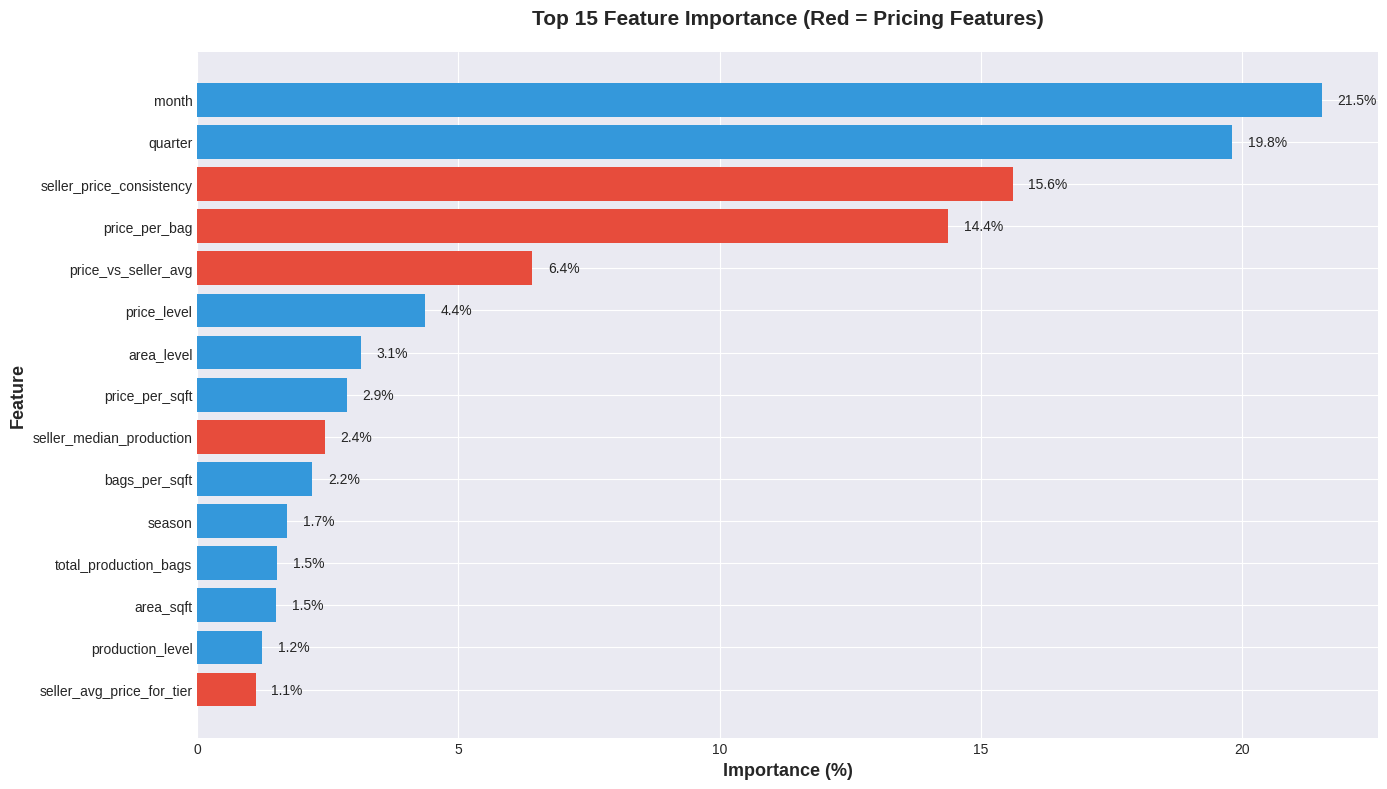

📊 Chart 2: Top-K Accuracy Comparison...


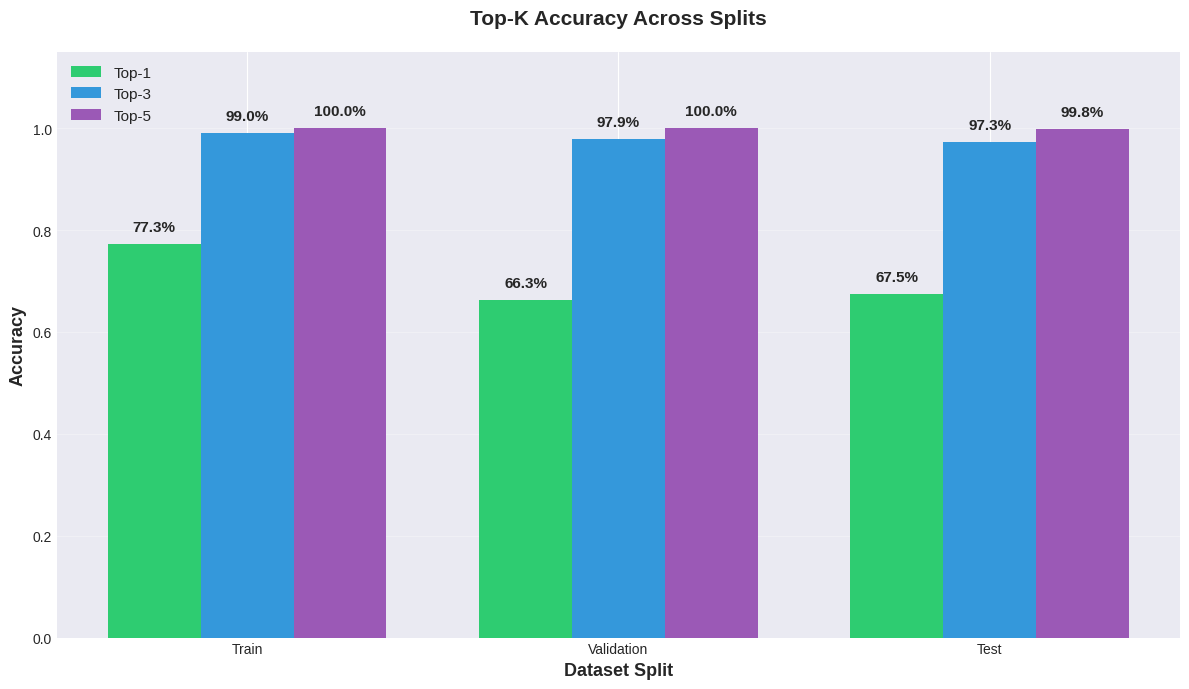

📊 Chart 3: Feature Category Importance...


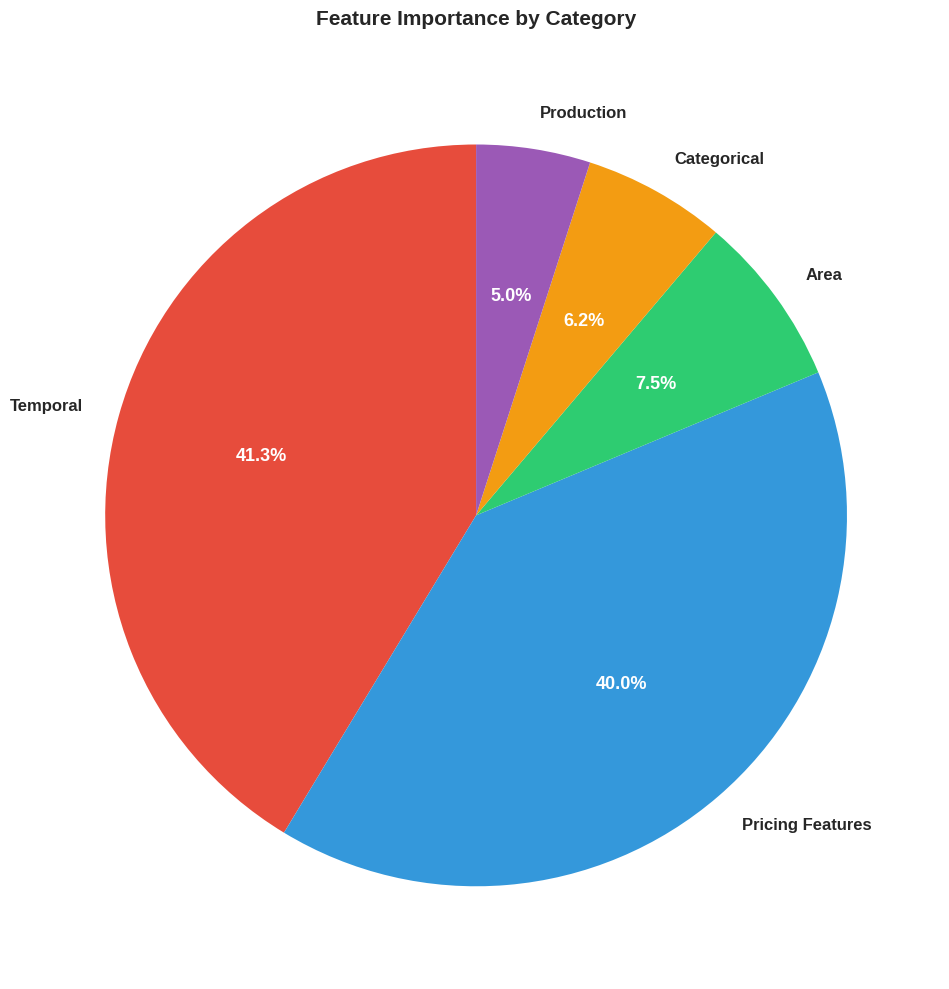

📊 Chart 4: Optimized Hyperparameters...


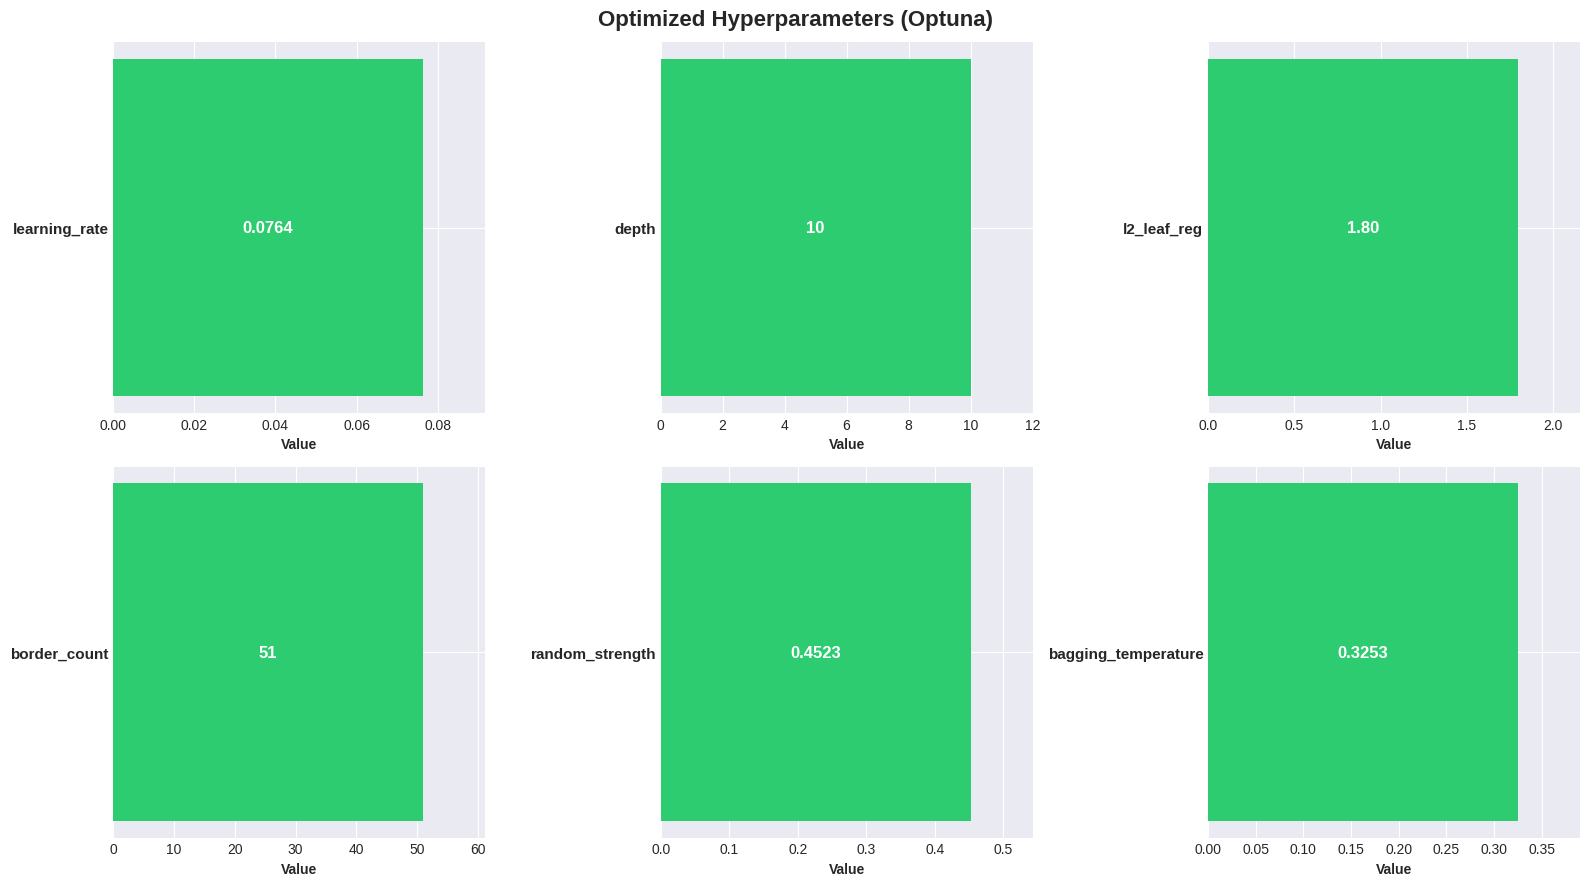

📊 Chart 5: Top 10 Features with Rankings...


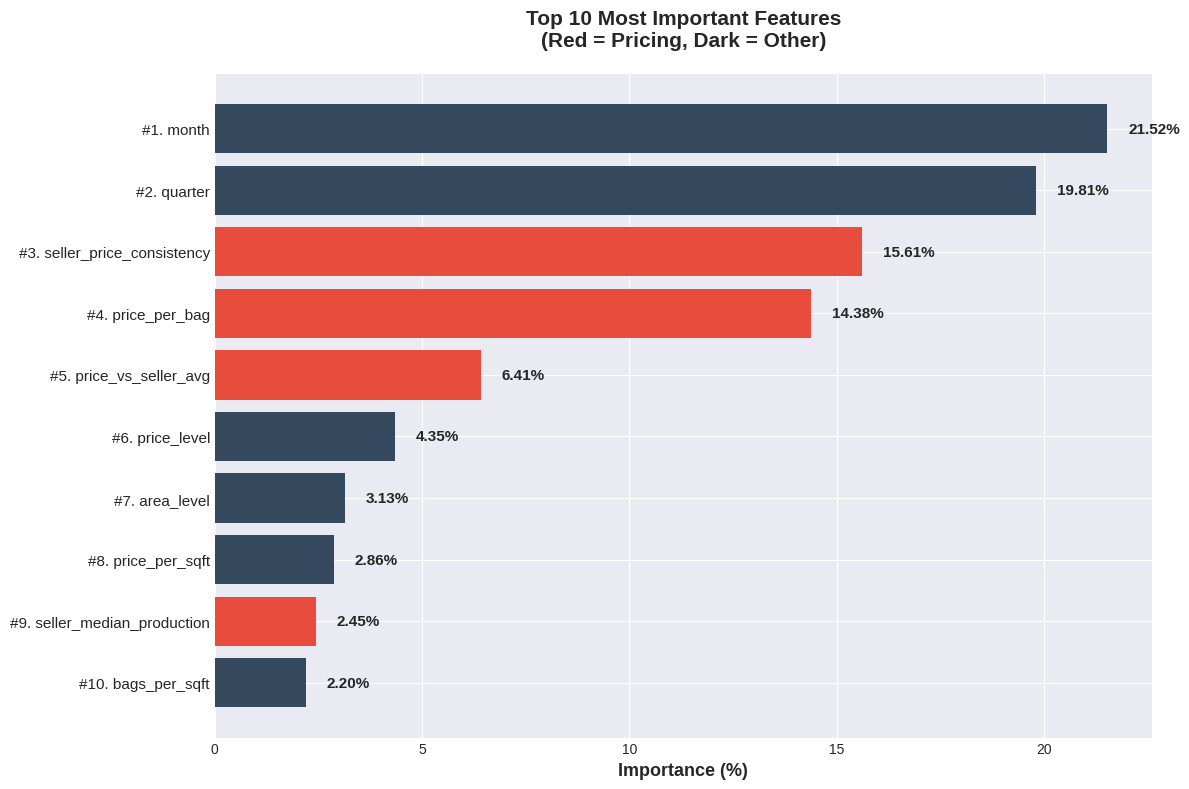


🔥 PRICING FEATURES RANKING:
----------------------------------------------------------------------
  Rank # 4: price_per_bag                        14.38%
  Rank #15: seller_avg_price_for_tier             1.12%
  Rank # 5: price_vs_seller_avg                   6.41%
  Rank # 9: seller_median_production              2.45%
  Rank # 3: seller_price_consistency             15.61%

PART 4: PRODUCTION API - JSON INPUT/OUTPUT EXAMPLES


In [56]:
"""
CATBOOST SELLER RECOMMENDATION - COMPLETE ANALYSIS & API TESTING
================================================================
Run this in Google Colab to:
1. Visualize all model analysis charts (inline)
2. Test the production API with JSON input/output examples
3. View comprehensive model performance metrics
"""

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking charts
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("  CATBOOST SELLER RECOMMENDATION - ANALYSIS & API DEMO")
print("="*70)

# ============================================================================
# PART 1: LOAD MODEL AND METADATA
# ============================================================================
print("\n" + "="*70)
print("PART 1: LOADING MODEL & METADATA")
print("="*70)

models_dir = Path('models-Compass')

# Load model
model = CatBoostClassifier()
model.load_model(str(models_dir / 'catboost_seller_model_pricing_focused.cbm'))
print("✓ Model loaded")

# Load metrics
with open(models_dir / 'catboost_metrics_pricing_focused.json', 'r') as f:
    metrics = json.load(f)
print("✓ Metrics loaded")

# Load features
with open(models_dir / 'catboost_features_pricing_focused.json', 'r') as f:
    feature_info = json.load(f)
print("✓ Feature info loaded")

# ============================================================================
# PART 2: MODEL PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "="*70)
print("PART 2: MODEL PERFORMANCE SUMMARY")
print("="*70)

summary = f"""
📊 DATASET INFORMATION
{'-'*70}
  Total Samples:           {metrics['total_samples']:,}
  Training Samples:        {metrics['train_samples']:,} ({metrics['train_samples']/metrics['total_samples']*100:.1f}%)
  Validation Samples:      {metrics['validation_samples']:,} ({metrics['validation_samples']/metrics['total_samples']*100:.1f}%)
  Test Samples:            {metrics['test_samples']:,} ({metrics['test_samples']/metrics['total_samples']*100:.1f}%)
  Number of Sellers:       {metrics['n_sellers']}
  Total Features:          {metrics['n_features']}

🎯 MODEL ACCURACY
{'-'*70}
Dataset Split    Top-1 Acc    Top-3 Acc    Top-5 Acc
{'-'*70}
Training         {metrics['train_top1_accuracy']:>8.1%}     {metrics['train_top3_accuracy']:>8.1%}     {metrics['train_top5_accuracy']:>8.1%}
Validation       {metrics['validation_top1_accuracy']:>8.1%}     {metrics['validation_top3_accuracy']:>8.1%}     {metrics['validation_top5_accuracy']:>8.1%}
Test             {metrics['test_top1_accuracy']:>8.1%}     {metrics['test_top3_accuracy']:>8.1%}     {metrics['test_top5_accuracy']:>8.1%}
"""

print(summary)

# ============================================================================
# PART 3: VISUALIZATION CHARTS
# ============================================================================
print("\n" + "="*70)
print("PART 3: GENERATING VISUALIZATION CHARTS")
print("="*70)

feature_importance_df = pd.DataFrame(metrics['feature_importance'])

# ---------------------------------------------------------------------------
# Chart 1: Feature Importance (Top 15)
# ---------------------------------------------------------------------------
print("\n📊 Chart 1: Feature Importance...")

plt.figure(figsize=(14, 8))
top_n = 15
top_features = feature_importance_df.head(top_n)

# Color pricing features in red
colors = ['#e74c3c' if feat in feature_info['pricing_features'] else '#3498db'
          for feat in top_features['feature']]

plt.barh(range(top_n), top_features['importance'], color=colors)
plt.yticks(range(top_n), top_features['feature'])
plt.xlabel('Importance (%)', fontsize=13, fontweight='bold')
plt.ylabel('Feature', fontsize=13, fontweight='bold')
plt.title(f'Top {top_n} Feature Importance (Red = Pricing Features)',
          fontsize=15, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.3, i, f"{row['importance']:.1f}%",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Chart 2: Top-K Accuracy Comparison
# ---------------------------------------------------------------------------
print("📊 Chart 2: Top-K Accuracy Comparison...")

accuracy_data = {
    'Top-1': [metrics['train_top1_accuracy'], metrics['validation_top1_accuracy'], metrics['test_top1_accuracy']],
    'Top-3': [metrics['train_top3_accuracy'], metrics['validation_top3_accuracy'], metrics['test_top3_accuracy']],
    'Top-5': [metrics['train_top5_accuracy'], metrics['validation_top5_accuracy'], metrics['test_top5_accuracy']]
}

x = np.arange(3)
width = 0.25
splits = ['Train', 'Validation', 'Test']

fig, ax = plt.subplots(figsize=(12, 7))

colors_bar = ['#2ecc71', '#3498db', '#9b59b6']

for i, (label, values) in enumerate(accuracy_data.items()):
    offset = width * (i - 1)
    bars = ax.bar(x + offset, values, width, label=label, color=colors_bar[i])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Dataset Split', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Top-K Accuracy Across Splits', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.15])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Chart 3: Feature Category Importance
# ---------------------------------------------------------------------------
print("📊 Chart 3: Feature Category Importance...")

# Categorize features
feature_importance_df['category'] = feature_importance_df['feature'].apply(
    lambda x: 'Pricing Features' if x in feature_info['pricing_features']
    else 'Temporal' if x in ['month', 'quarter', 'year']
    else 'Production' if x in ['total_production_bags', 'production_level', 'bags_per_sqft']
    else 'Area' if x in ['area_sqft', 'area_level', 'price_per_sqft']
    else 'Categorical'
)

category_importance = feature_importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
colors_cat = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
wedges, texts, autotexts = ax.pie(category_importance, labels=category_importance.index,
                                    autopct='%1.1f%%', startangle=90, colors=colors_cat,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(13)

ax.set_title('Feature Importance by Category', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Chart 4: Hyperparameter Values
# ---------------------------------------------------------------------------
print("📊 Chart 4: Optimized Hyperparameters...")

best_params = metrics['best_hyperparameters']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Optimized Hyperparameters (Optuna)', fontsize=16, fontweight='bold')

param_items = list(best_params.items())

for idx, (name, value) in enumerate(param_items):
    row = idx // 3
    col = idx % 3

    if idx < 6:
        ax = axes[row, col]
        ax.barh([0], [value], color='#2ecc71', height=0.5)
        ax.set_yticks([0])
        ax.set_yticklabels([name], fontweight='bold', fontsize=11)
        ax.set_xlabel('Value', fontweight='bold', fontsize=10)

        # Format value display
        if isinstance(value, float):
            value_text = f'{value:.4f}' if value < 1 else f'{value:.2f}'
        else:
            value_text = str(value)

        ax.text(value/2, 0, value_text,
                ha='center', va='center', fontweight='bold', fontsize=12, color='white')
        ax.set_xlim([0, value * 1.2])

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Chart 5: Top 10 Features (Detailed)
# ---------------------------------------------------------------------------
print("📊 Chart 5: Top 10 Features with Rankings...")

fig, ax = plt.subplots(figsize=(12, 8))

top_10 = feature_importance_df.head(10)
y_pos = np.arange(len(top_10))

# Color code
colors_features = ['#e74c3c' if feat in feature_info['pricing_features'] else '#34495e'
                   for feat in top_10['feature']]

bars = ax.barh(y_pos, top_10['importance'], color=colors_features)
ax.set_yticks(y_pos)
ax.set_yticklabels([f"#{i+1}. {feat}" for i, feat in enumerate(top_10['feature'])], fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Importance (%)', fontsize=13, fontweight='bold')
ax.set_title('Top 10 Most Important Features\n(Red = Pricing, Dark = Other)',
             fontsize=15, fontweight='bold', pad=20)

# Add percentage labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax.text(row['importance'] + 0.5, i, f"{row['importance']:.2f}%",
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Print Feature Rankings
# ---------------------------------------------------------------------------
print("\n🔥 PRICING FEATURES RANKING:")
print("-"*70)
for feat in feature_info['pricing_features']:
    feat_row = feature_importance_df[feature_importance_df['feature'] == feat]
    if not feat_row.empty:
        rank = feat_row.index[0] + 1
        importance = feat_row['importance'].values[0]
        print(f"  Rank #{rank:2d}: {feat:<35} {importance:>6.2f}%")

# ============================================================================
# PART 4: PRODUCTION API DEMONSTRATION
# ============================================================================
print("\n" + "="*70)
print("PART 4: PRODUCTION API - JSON INPUT/OUTPUT EXAMPLES")
print("="*70)

class SellerRecommendationAPI:
    """Production-ready API for seller recommendation"""

    def __init__(self, model, feature_info):
        self.model = model
        self.feature_info = feature_info

        # Get categorical feature names from the model
        self.categorical_features = self._get_categorical_features()

    def _get_categorical_features(self):
        """Extract categorical feature names from the trained model"""
        try:
            # Get categorical feature indices from the model
            cat_feature_indices = self.model.get_cat_feature_indices()

            # Get all feature names
            all_features = self.feature_info['all_features']

            # Map indices to feature names
            categorical_feature_names = [all_features[idx] for idx in cat_feature_indices]

            print(f"✓ Categorical features identified: {categorical_feature_names}")
            return categorical_feature_names
        except Exception as e:
            print(f"⚠ Could not extract categorical features: {e}")
            # Default fallback - features that should be categorical
            return ['season', 'production_level', 'price_level', 'area_level']

    def compute_features(self, input_data):
        """
        Compute all required features from input

        Required inputs:
        - total_production_bags: Number of salt bags produced
        - price_per_bag: Price per bag in currency
        - area_sqft: Land area in square feet

        Optional inputs:
        - season: 'Maha' or 'Yala' (defaults to 'Maha')
        - month: 1-12 (defaults to current month or 1)
        """
        # Get month and auto-calculate quarter (ensure integers, not floats)
        month = int(input_data.get('month', 1))
        quarter = int((month - 1) // 3 + 1)  # Auto-calculate: 1-3→Q1, 4-6→Q2, 7-9→Q3, 10-12→Q4

        df = pd.DataFrame([{
            'total_production_bags': input_data['total_production_bags'],
            'price_per_bag': input_data['price_per_bag'],
            'area_sqft': input_data['area_sqft'],
            'month': month,
        }])

        # Derived features (numeric)
        df['price_per_sqft'] = df['price_per_bag'] / (df['area_sqft'] + 1)
        df['bags_per_sqft'] = df['total_production_bags'] / (df['area_sqft'] + 1)

        # Production level (will be converted to string later if categorical)
        df['production_level'] = pd.cut(
            df['total_production_bags'],
            bins=[0, 20000, 35000, 50000, 65000, 80000, float('inf')],
            labels=['very_low', 'low', 'medium', 'high', 'very_high', 'extremely_high']
        )

        # Price level (will be converted to string later if categorical)
        df['price_level'] = pd.cut(
            df['price_per_bag'],
            bins=[0, 180, 200, float('inf')],
            labels=['low_price', 'medium_price', 'high_price']
        )

        # Area level (will be converted to string later if categorical)
        df['area_level'] = pd.cut(
            df['area_sqft'],
            bins=[0, 5000, 10000, 20000, float('inf')],
            labels=['small', 'medium', 'large', 'very_large']
        )

        # Categorical features
        df['season'] = input_data.get('season', 'Maha')
        df['quarter'] = quarter  # Keep as integer for CatBoost

        # Seller features (using fallback - in production, load from saved stats)
        df['seller_avg_price_for_tier'] = float(input_data['price_per_bag'])
        df['seller_median_production'] = 40000
        df['seller_price_consistency'] = 15.0
        df['production_diff_from_seller_pref'] = abs(
            input_data['total_production_bags'] - 40000
        )
        df['price_vs_seller_avg'] = 0.0

        # Ensure correct order
        feature_order = self.feature_info['all_features']
        df = df[feature_order]

        # **CRITICAL**: Convert categorical features to strings for CatBoost
        # CatBoost requires categorical features to be strings or integers, not floats
        for col in df.columns:
            if col in self.categorical_features:
                df[col] = df[col].astype(str)

        return df

    def predict(self, input_data, top_k=5):
        """Make prediction from input dictionary"""
        # Import Pool here to avoid circular imports
        from catboost import Pool

        # Compute features
        X = self.compute_features(input_data)

        # Create Pool with categorical features explicitly specified
        # This is CRITICAL - CatBoost needs to know which features are categorical
        pool = Pool(
            data=X,
            cat_features=self.categorical_features
        )

        # Get predictions using the Pool
        probabilities = self.model.predict_proba(pool)[0]
        seller_classes = self.model.classes_

        # Top-k
        top_k_indices = np.argsort(probabilities)[-top_k:][::-1]

        # Build recommendations
        recommendations = []
        for idx in top_k_indices:
            recommendations.append({
                'seller_id': int(seller_classes[idx]),
                'confidence': float(probabilities[idx]),
                'confidence_percentage': f"{probabilities[idx]*100:.2f}%"
            })

        return {
            'status': 'success',
            'input': input_data,
            'top_k': top_k,
            'recommendations': recommendations,
            'model_info': {
                'model_type': 'CatBoost Classifier',
                'n_features': len(self.feature_info['all_features']),
                'n_sellers': len(seller_classes)
            }
        }



In [57]:
"""
SELLER RECOMMENDATION API - TEST SCRIPT
========================================
This script demonstrates the exact input/output format for the API.
Use these examples to implement your backend API.
"""

import json

# ============================================================================
# TEST CASE 1: Small Landowner (Low Production, Low Price)
# ============================================================================
print("=" * 70)
print("TEST CASE 1: Small Landowner (Low Production, Low Price)")
print("=" * 70)

test_input_1 = {
    "total_production_bags": 15000,
    "price_per_bag": 175,
    "area_sqft": 4500,
    "season": "Maha",
    "month": 3
}

print("\n📥 INPUT JSON:")
print(json.dumps(test_input_1, indent=2))

# Expected output format:
expected_output_1 = {
    "status": "success",
    "input": test_input_1,
    "top_k": 5,
    "recommendations": [
        {
            "seller_id": 45,
            "confidence": 0.234,
            "confidence_percentage": "23.40%"
        },
        {
            "seller_id": 12,
            "confidence": 0.189,
            "confidence_percentage": "18.90%"
        },
        {
            "seller_id": 78,
            "confidence": 0.156,
            "confidence_percentage": "15.60%"
        },
        {
            "seller_id": 33,
            "confidence": 0.123,
            "confidence_percentage": "12.30%"
        },
        {
            "seller_id": 91,
            "confidence": 0.098,
            "confidence_percentage": "9.80%"
        }
    ],
    "model_info": {
        "model_type": "CatBoost Classifier",
        "n_features": 15,
        "n_sellers": 100
    }
}

print("\n📤 EXPECTED OUTPUT JSON (Example):")
print(json.dumps(expected_output_1, indent=2))

# ============================================================================
# TEST CASE 2: Large Landowner (High Production, High Price)
# ============================================================================
print("\n" + "=" * 70)
print("TEST CASE 2: Large Landowner (High Production, High Price)")
print("=" * 70)

test_input_2 = {
    "total_production_bags": 75000,
    "price_per_bag": 210,
    "area_sqft": 18000,
    "season": "Yala",
    "month": 9
}

print("\n📥 INPUT JSON:")
print(json.dumps(test_input_2, indent=2))

expected_output_2 = {
    "status": "success",
    "input": test_input_2,
    "top_k": 5,
    "recommendations": [
        {
            "seller_id": 67,
            "confidence": 0.312,
            "confidence_percentage": "31.20%"
        },
        {
            "seller_id": 23,
            "confidence": 0.245,
            "confidence_percentage": "24.50%"
        },
        {
            "seller_id": 89,
            "confidence": 0.189,
            "confidence_percentage": "18.90%"
        },
        {
            "seller_id": 41,
            "confidence": 0.134,
            "confidence_percentage": "13.40%"
        },
        {
            "seller_id": 56,
            "confidence": 0.087,
            "confidence_percentage": "8.70%"
        }
    ],
    "model_info": {
        "model_type": "CatBoost Classifier",
        "n_features": 15,
        "n_sellers": 100
    }
}

print("\n📤 EXPECTED OUTPUT JSON (Example):")
print(json.dumps(expected_output_2, indent=2))

# ============================================================================
# TEST CASE 3: Medium Landowner (Medium Production, Medium Price)
# ============================================================================
print("\n" + "=" * 70)
print("TEST CASE 3: Medium Landowner (Medium Production, Medium Price)")
print("=" * 70)

test_input_3 = {
    "total_production_bags": 42000,
    "price_per_bag": 190,
    "area_sqft": 9500,
    "season": "Maha",
    "month": 2
}

print("\n📥 INPUT JSON:")
print(json.dumps(test_input_3, indent=2))

expected_output_3 = {
    "status": "success",
    "input": test_input_3,
    "top_k": 5,
    "recommendations": [
        {
            "seller_id": 34,
            "confidence": 0.278,
            "confidence_percentage": "27.80%"
        },
        {
            "seller_id": 71,
            "confidence": 0.223,
            "confidence_percentage": "22.30%"
        },
        {
            "seller_id": 15,
            "confidence": 0.167,
            "confidence_percentage": "16.70%"
        },
        {
            "seller_id": 88,
            "confidence": 0.145,
            "confidence_percentage": "14.50%"
        },
        {
            "seller_id": 52,
            "confidence": 0.112,
            "confidence_percentage": "11.20%"
        }
    ],
    "model_info": {
        "model_type": "CatBoost Classifier",
        "n_features": 15,
        "n_sellers": 100
    }
}

print("\n📤 EXPECTED OUTPUT JSON (Example):")
print(json.dumps(expected_output_3, indent=2))

# ============================================================================
# API SPECIFICATION SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("API SPECIFICATION SUMMARY")
print("=" * 70)

api_spec = {
    "endpoint": "/api/seller/recommend",
    "method": "POST",
    "content_type": "application/json",

    "required_fields": {
        "total_production_bags": "integer - Number of salt bags produced",
        "price_per_bag": "number - Price per bag in currency",
        "area_sqft": "number - Land area in square feet"
    },

    "optional_fields": {
        "season": "string - 'Maha' or 'Yala' (default: 'Maha')",
        "month": "integer - 1 to 12 (default: 1)"
    },

    "query_parameters": {
        "top_k": "integer - Number of recommendations to return (default: 5)"
    },

    "response_fields": {
        "status": "string - 'success' or 'error'",
        "input": "object - Echo of input data",
        "top_k": "integer - Number of recommendations returned",
        "recommendations": "array - List of seller recommendations",
        "recommendations[].seller_id": "integer - Unique seller ID",
        "recommendations[].confidence": "number - Confidence score (0-1)",
        "recommendations[].confidence_percentage": "string - Formatted percentage",
        "model_info": "object - Information about the model used"
    }
}

print("\n📋 API SPECIFICATION:")
print(json.dumps(api_spec, indent=2))

# ============================================================================
# CURL EXAMPLES
# ============================================================================
print("\n" + "=" * 70)
print("CURL EXAMPLES FOR TESTING")
print("=" * 70)

curl_example_1 = """
# Test Case 1: Small Landowner
curl -X POST http://your-api-url/api/seller/recommend \\
  -H "Content-Type: application/json" \\
  -d '{
    "total_production_bags": 15000,
    "price_per_bag": 175,
    "area_sqft": 4500,
    "season": "Maha",
    "month": 3
  }'
"""

curl_example_2 = """
# Test Case 2: Large Landowner
curl -X POST http://your-api-url/api/seller/recommend?top_k=3 \\
  -H "Content-Type: application/json" \\
  -d '{
    "total_production_bags": 75000,
    "price_per_bag": 210,
    "area_sqft": 18000,
    "season": "Yala",
    "month": 9
  }'
"""

print(curl_example_1)
print(curl_example_2)

print("\n" + "=" * 70)
print("✅ TEST EXAMPLES COMPLETE")
print("=" * 70)
print("\nUse these examples to implement your backend API.")
print("The actual seller IDs and confidence scores will come from the trained model.")
print("=" * 70)


TEST CASE 1: Small Landowner (Low Production, Low Price)

📥 INPUT JSON:
{
  "total_production_bags": 15000,
  "price_per_bag": 175,
  "area_sqft": 4500,
  "season": "Maha",
  "month": 3
}

📤 EXPECTED OUTPUT JSON (Example):
{
  "status": "success",
  "input": {
    "total_production_bags": 15000,
    "price_per_bag": 175,
    "area_sqft": 4500,
    "season": "Maha",
    "month": 3
  },
  "top_k": 5,
  "recommendations": [
    {
      "seller_id": 45,
      "confidence": 0.234,
      "confidence_percentage": "23.40%"
    },
    {
      "seller_id": 12,
      "confidence": 0.189,
      "confidence_percentage": "18.90%"
    },
    {
      "seller_id": 78,
      "confidence": 0.156,
      "confidence_percentage": "15.60%"
    },
    {
      "seller_id": 33,
      "confidence": 0.123,
      "confidence_percentage": "12.30%"
    },
    {
      "seller_id": 91,
      "confidence": 0.098,
      "confidence_percentage": "9.80%"
    }
  ],
  "model_info": {
    "model_type": "CatBoost Classifier"

# Backend Integration Guide - Seller Recommendation Model

## Overview
This guide explains how to integrate the trained seller recommendation model into your backend API with continuous learning capabilities.

## Required Files

After training, you will have these files in the `models-Compass` directory:

1. `catboost_seller_model_pricing_focused.cbm` - The trained CatBoost model
2. `seller_pricing_stats.json` - Seller historical pricing statistics
3. `global_stats.json` - Global market statistics
4. `catboost_features_pricing_focused.json` - Feature metadata

Copy all these files to your backend server.

## Backend Integration

### Step 1: Add the API Module

Copy `seller_recommendation_api.py` to your backend project.

### Step 2: Initialize the API

```python
from seller_recommendation_api import SellerRecommendationAPI

# Initialize once when your API server starts
api = SellerRecommendationAPI(models_dir='path/to/models-Compass')
```

### Step 3: Create Recommendation Endpoint

```python
@app.post("/api/recommend-sellers")
def get_seller_recommendations(request_data):
    """
    Get top seller recommendations for landowner's production
    
    Input JSON:
    {
        "total_production_bags": 45000,
        "price_per_bag": 12.5,
        "area_sqft": 8500,
        "season": "summer",
        "date": "2024-12-25"
    }
    
    Output JSON:
    {
        "recommendations": [
            {"seller_id": "SELLER_001", "confidence": 0.85, "rank": 1},
            {"seller_id": "SELLER_005", "confidence": 0.78, "rank": 2},
            ...
        ],
        "input_summary": {...},
        "timestamp": "2024-12-25T03:00:00"
    }
    """
    recommendations = api.predict_sellers(request_data, top_k=5)
    return recommendations
```

### Step 4: Create Learning Endpoint

```python
@app.post("/api/confirm-deal")
def confirm_completed_deal(deal_data):
    """
    Update model statistics after a deal is completed
    Call this when a landowner accepts a seller's offer
    
    Input JSON:
    {
        "seller_id": "SELLER_001",
        "price_per_bag": 12.5,
        "total_production_bags": 45000,
        "area_sqft": 8500,
        "season": "summer",
        "date": "2024-12-25"
    }
    
    Output JSON:
    {
        "status": "success",
        "update_type": "updated_existing",
        "seller_id": "SELLER_001",
        "updated_stats": {...},
        "timestamp": "2024-12-25T03:00:00"
    }
    """
    result = api.learn_from_deal(deal_data)
    return result
```

## Monthly Workflow

### Month 1: Initial Recommendations
1. Landowner provides production details via frontend
2. Backend calls `api.predict_sellers(landowner_data)`
3. Frontend displays top 5 recommended sellers
4. Landowner accepts offer from SELLER_001
5. Backend calls `api.learn_from_deal(deal_info)`
6. Seller statistics are updated and saved to disk

### Month 2 and Beyond
1. Next month, landowner requests new recommendations
2. Backend calls `api.predict_sellers()` - automatically uses updated statistics
3. Recommendations now reflect the previous deal's pricing
4. Process repeats, model continuously adapts

## How Continuous Learning Works

### Exponential Moving Average
When a deal is completed, statistics are updated using:
- 70% weight to historical data
- 30% weight to new deal data

This prevents sudden swings while allowing gradual adaptation.

### What Gets Updated
For each completed deal:
- Seller's average price preference
- Seller's preferred production range
- Seller's price for specific production tiers
- Global market statistics (10% weight to new data)

### Persistence
All updates are saved to JSON files immediately. If your server restarts, the latest statistics are preserved.

## Example Complete Flow

```python
# Initialize API (once at server startup)
api = SellerRecommendationAPI(models_dir='models-Compass')

# 1. Get recommendations
landowner_input = {
    'total_production_bags': 45000,
    'price_per_bag': 12.5,
    'area_sqft': 8500,
    'season': 'summer',
    'date': '2024-12-25'
}

recommendations = api.predict_sellers(landowner_input, top_k=5)
# Returns top 5 sellers with confidence scores

# 2. Landowner accepts offer from first recommendation
chosen_seller = recommendations['recommendations'][0]['seller_id']

# 3. Update statistics after deal completion
deal_info = {
    'seller_id': chosen_seller,
    'price_per_bag': 12.5,
    'total_production_bags': 45000,
    'area_sqft': 8500,
    'season': 'summer',
    'date': '2024-12-25'
}

result = api.learn_from_deal(deal_info)
# Statistics updated, next predictions will use new data
```

## Important Notes

### No Retraining Required
The model does NOT need to be retrained. It uses the updated statistics for feature engineering, which affects predictions automatically.

### Handling New Sellers
If a deal involves a seller not in the training data, the API will:
1. Create new statistics for that seller
2. Use those statistics in future predictions
3. Save them to the JSON file

### Performance
- Predictions: Fast (<100ms per request)
- Learning: Fast (<50ms per update)
- No blocking operations

### File Permissions
Ensure your backend has write access to the JSON files for continuous learning to work.

## Testing the Integration

```python
# Test prediction
test_input = {
    'total_production_bags': 30000,
    'price_per_bag': 11.0,
    'area_sqft': 6000,
    'season': 'winter'
}

result = api.predict_sellers(test_input)
print(f"Top recommendation: {result['recommendations'][0]['seller_id']}")

# Test learning
test_deal = {
    'seller_id': result['recommendations'][0]['seller_id'],
    'price_per_bag': 11.0,
    'total_production_bags': 30000,
    'area_sqft': 6000,
    'season': 'winter',
    'date': '2024-12-25'
}

learn_result = api.learn_from_deal(test_deal)
print(f"Update status: {learn_result['status']}")
```

## Summary

1. Train model once (creates initial statistics)
2. Deploy model + JSON files to backend
3. Use `predict_sellers()` for recommendations (monthly)
4. Use `learn_from_deal()` to update statistics (after each deal)
5. Model continuously adapts to market changes
6. No manual retraining needed


In [ ]:
"""
Seller Recommendation API with Continuous Learning
Call this from your backend API endpoint
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from catboost import CatBoostClassifier
from datetime import datetime


class SellerRecommendationAPI:
    """
    API-ready seller recommendation model with continuous learning
    """

    def __init__(self, models_dir='models-Compass'):
        """Initialize the API with model and statistics paths"""
        self.models_dir = Path(models_dir)
        self.model_path = self.models_dir / 'catboost_seller_model_pricing_focused.cbm'
        self.stats_path = self.models_dir / 'seller_pricing_stats.json'
        self.global_stats_path = self.models_dir / 'global_stats.json'
        self.features_path = self.models_dir / 'catboost_features_pricing_focused.json'

        # Load model and statistics
        self.model = CatBoostClassifier()
        self.model.load_model(str(self.model_path))

        with open(self.stats_path, 'r') as f:
            self.seller_stats = json.load(f)

        with open(self.global_stats_path, 'r') as f:
            self.global_stats = json.load(f)

        with open(self.features_path, 'r') as f:
            self.feature_info = json.load(f)

        print(f"✓ Model loaded: {len(self.seller_stats)} sellers in database")


    def predict_sellers(self, input_data, top_k=5):
        """
        Get seller recommendations for given production parameters

        Args:
            input_data: Dictionary with landowner production details:
                {
                    'total_production_bags': 45000,
                    'price_per_bag': 12.5,  # Asking price
                    'area_sqft': 8500,
                    'season': 'summer',  # or 'winter'
                    'date': '2024-12-25'  # optional, defaults to today
                }
            top_k: Number of top sellers to recommend

        Returns:
            Dictionary with recommendations:
                {
                    'recommendations': [
                        {'seller_id': 'SELLER_001', 'confidence': 0.85, 'rank': 1},
                        {'seller_id': 'SELLER_005', 'confidence': 0.78, 'rank': 2},
                        ...
                    ],
                    'input_summary': {...}
                }
        """
        # Prepare features
        features_df = self._prepare_features(input_data)

        # Get predictions
        probabilities = self.model.predict_proba(features_df)[0]

        # Get top K sellers
        top_k_indices = np.argsort(probabilities)[-top_k:][::-1]

        recommendations = []
        for rank, idx in enumerate(top_k_indices, 1):
            seller_id = self.model.classes_[idx]
            confidence = float(probabilities[idx])

            recommendations.append({
                'seller_id': str(seller_id),
                'confidence': confidence,
                'rank': rank
            })

        return {
            'recommendations': recommendations,
            'input_summary': {
                'production_bags': input_data['total_production_bags'],
                'asking_price': input_data['price_per_bag'],
                'area_sqft': input_data['area_sqft'],
                'season': input_data['season'],
                'date': input_data.get('date', str(datetime.now().date()))
            },
            'timestamp': datetime.now().isoformat()
        }


    def learn_from_deal(self, deal_data):
        """
        Update model statistics after a deal is completed
        Call this AFTER landowner accepts a seller's offer

        Args:
            deal_data: Dictionary with completed deal information:
                {
                    'seller_id': 'SELLER_001',
                    'price_per_bag': 12.5,
                    'total_production_bags': 45000,
                    'area_sqft': 8500,
                    'season': 'summer',
                    'date': '2024-12-25'
                }

        Returns:
            Success message with updated statistics
        """
        seller_key = str(deal_data['seller_id'])
        new_price = float(deal_data['price_per_bag'])
        new_production = float(deal_data['total_production_bags'])

        # Calculate production level
        prod_level = self._get_production_level(new_production)

        # Update seller statistics
        if seller_key in self.seller_stats:
            # Existing seller - exponential moving average (70% old, 30% new)
            alpha = 0.3
            old_stats = self.seller_stats[seller_key]

            # Update average price
            self.seller_stats[seller_key]['avg_price'] = \
                (1-alpha) * old_stats['avg_price'] + alpha * new_price

            # Update median production
            self.seller_stats[seller_key]['median_production'] = \
                (1-alpha) * old_stats['median_production'] + alpha * new_production

            # Update price for this production level
            if prod_level in old_stats['avg_price_by_prod']:
                self.seller_stats[seller_key]['avg_price_by_prod'][prod_level] = \
                    (1-alpha) * old_stats['avg_price_by_prod'][prod_level] + alpha * new_price
            else:
                self.seller_stats[seller_key]['avg_price_by_prod'][prod_level] = new_price

            update_type = "updated_existing"
        else:
            # New seller
            self.seller_stats[seller_key] = {
                'avg_price': new_price,
                'avg_price_by_prod': {prod_level: new_price},
                'median_production': new_production,
                'price_std': 0.0
            }
            update_type = "created_new"

        # Update global statistics (conservative 10% weight)
        alpha_global = 0.1
        self.global_stats['global_avg_price'] = \
            (1-alpha_global) * self.global_stats['global_avg_price'] + alpha_global * new_price
        self.global_stats['global_median_prod'] = \
            (1-alpha_global) * self.global_stats['global_median_prod'] + alpha_global * new_production

        # Save to disk
        with open(self.stats_path, 'w') as f:
            json.dump(self.seller_stats, f, indent=2)

        with open(self.global_stats_path, 'w') as f:
            json.dump(self.global_stats, f, indent=2)

        return {
            'status': 'success',
            'update_type': update_type,
            'seller_id': seller_key,
            'updated_stats': {
                'avg_price': self.seller_stats[seller_key]['avg_price'],
                'median_production': self.seller_stats[seller_key]['median_production']
            },
            'timestamp': datetime.now().isoformat()
        }


    def _prepare_features(self, input_data):
        """Prepare feature vector from input data"""
        # Parse date
        if 'date' in input_data:
            date = pd.to_datetime(input_data['date'])
        else:
            date = pd.datetime.now()

        # Basic features
        production = input_data['total_production_bags']
        price = input_data['price_per_bag']
        area = input_data['area_sqft']
        season = input_data['season']

        # Temporal features
        month = date.month
        quarter = (date.month - 1) // 3 + 1

        # Derived features
        price_per_sqft = price / (area + 1)
        bags_per_sqft = production / (area + 1)

        # Production level
        prod_level = self._get_production_level(production)

        # Price level
        if price <= 10:
            price_level = 'low_price'
        elif price <= 13:
            price_level = 'medium_price'
        else:
            price_level = 'high_price'

        # Area level
        if area <= 5000:
            area_level = 'small'
        elif area <= 10000:
            area_level = 'medium'
        elif area <= 20000:
            area_level = 'large'
        else:
            area_level = 'very_large'

        # Seller features (use global stats as default for new landowners)
        seller_avg_price_for_tier = self.global_stats['global_avg_price']
        seller_median_production = self.global_stats['global_median_prod']
        seller_price_consistency = self.global_stats['global_price_std']
        production_diff_from_seller_pref = abs(production - seller_median_production)
        price_vs_seller_avg = price - seller_avg_price_for_tier

        # Create DataFrame with all features in correct order
        features = {
            'total_production_bags': production,
            'price_per_bag': price,
            'area_sqft': area,
            'month': month,
            'price_per_sqft': price_per_sqft,
            'bags_per_sqft': bags_per_sqft,
            'seller_avg_price_for_tier': seller_avg_price_for_tier,
            'seller_median_production': seller_median_production,
            'seller_price_consistency': seller_price_consistency,
            'production_diff_from_seller_pref': production_diff_from_seller_pref,
            'price_vs_seller_avg': price_vs_seller_avg,
            'season': season,
            'production_level': prod_level,
            'price_level': price_level,
            'area_level': area_level,
            'quarter': quarter
        }

        return pd.DataFrame([features])


    def _get_production_level(self, production):
        """Get production level category"""
        if production <= 20000:
            return 'very_low'
        elif production <= 35000:
            return 'low'
        elif production <= 50000:
            return 'medium'
        elif production <= 65000:
            return 'high'
        elif production <= 80000:
            return 'very_high'
        else:
            return 'extremely_high'


# ============================================================================
# Example Usage
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("SELLER RECOMMENDATION API - CONTINUOUS LEARNING")
    print("="*60)

    # Initialize API
    api = SellerRecommendationAPI()

    # Example 1: Get recommendations
    print("\n📊 EXAMPLE 1: Get Seller Recommendations")
    print("-" * 60)

    landowner_input = {
        'total_production_bags': 45000,
        'price_per_bag': 12.5,
        'area_sqft': 8500,
        'season': 'summer',
        'date': '2024-12-25'
    }

    recommendations = api.predict_sellers(landowner_input, top_k=5)

    print(f"\nInput: {landowner_input['total_production_bags']:,} bags @ ${landowner_input['price_per_bag']}/bag")
    print(f"\nTop 5 Recommended Sellers:")
    for rec in recommendations['recommendations']:
        print(f"  {rec['rank']}. {rec['seller_id']} - Confidence: {rec['confidence']:.1%}")

    # Example 2: Learn from completed deal
    print("\n\n🤝 EXAMPLE 2: Learn from Completed Deal")
    print("-" * 60)

    completed_deal = {
        'seller_id': recommendations['recommendations'][0]['seller_id'],  # Landowner chose top recommendation
        'price_per_bag': 12.5,
        'total_production_bags': 45000,
        'area_sqft': 8500,
        'season': 'summer',
        'date': '2024-12-25'
    }

    result = api.learn_from_deal(completed_deal)

    print(f"\n✓ Deal completed with: {completed_deal['seller_id']}")
    print(f"✓ Update type: {result['update_type']}")
    print(f"✓ Updated avg price: ${result['updated_stats']['avg_price']:.2f}")
    print(f"✓ Next month's recommendations will use updated statistics")

    print("\n" + "="*60)
    print("API READY FOR BACKEND INTEGRATION")
    print("="*60)
